In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.append('/home/kaigorodov/myprojects/MedConcNorm/')

from src.features.class_balancing import class_sampler
from src.features.TripletGenerator import TripletGenerator
from src.features.loss_functions import triplet_loss, identity_loss
from src.models.base_model import base_model
from src.models.siamese_model import siamese_model

from tqdm import tqdm

In [4]:
from imblearn.over_sampling import RandomOverSampler

In [12]:
from metric_learn import NCA


In [5]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from tensorflow.keras.callbacks import EarlyStopping

In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:
# with open('../data/processed/pure_data.pkl', 'rb') as data_file:
#     df = pickle.load(data_file)
    
with open('../data/processed/pure_data_vectorized.pkl', 'rb') as data_file:
    df = pickle.load(data_file)
    
X_train, X_test, y_train, y_test = df

# oversample = RandomOverSampler(sampling_strategy='minority')
# for i in tqdm(range(100)):
#     X_train, y_train = oversample.fit_resample(X_train, y_train)
#X_train, y_train = class_sampler(X_train, y_train)


X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2153, 768), (539, 768), (2153,), (539,))

In [8]:
np.unique(y_train).shape, np.unique(y_test).shape

((432,), (208,))

(<AxesSubplot:ylabel='Count'>, <AxesSubplot:ylabel='Count'>)

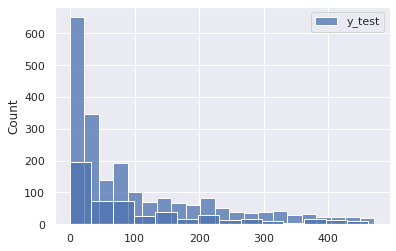

In [9]:
import pandas as pd
import seaborn as sns

sns.histplot(pd.DataFrame({'y_train':y_train})), sns.histplot(pd.DataFrame({'y_test':y_test}))

# Show changes

In [10]:
def scatter(x, labels, subtitle=None):
    palette = np.array(sns.color_palette("hls", 500))
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40, c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

(2153, 2) (2153,)


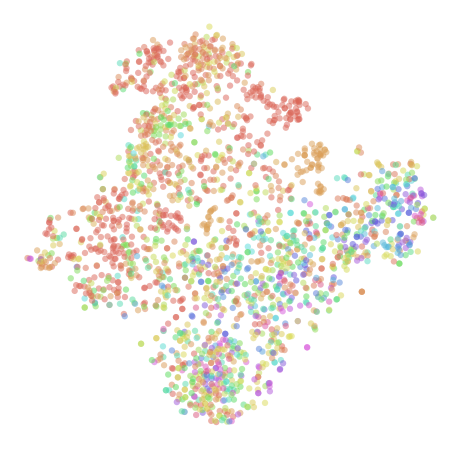

In [11]:
# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
train_tsne = tsne.fit_transform(X_train)
print(train_tsne.shape, y_train.shape)
scatter(train_tsne, y_train)

(2153, 2) (2153,)


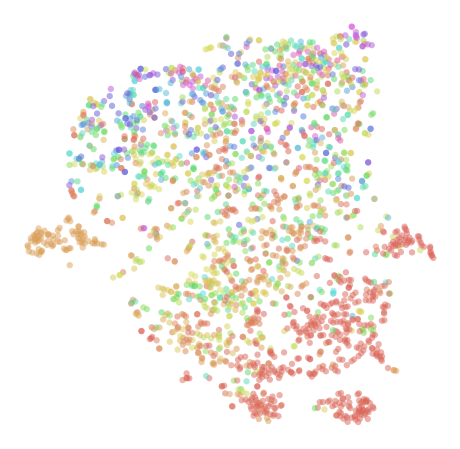

In [14]:
model = NCA(max_iter=500)
X_train_nca = model.fit_transform(X_train, y_train)

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_nca)
print(train_tsne_embeds.shape, y_train.shape)
scatter(train_tsne_embeds, y_train)

In [16]:
model = NCA(max_iter=3000)
X_train_nca = model.fit_transform(X_train, y_train)

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_nca)
print(train_tsne_embeds.shape, y_train.shape)
scatter(train_tsne_embeds, y_train)

KeyboardInterrupt: 

In [ ]:
tsne = TSNE()
test_tsne = tsne.fit_transform(X_test)
print(test_tsne.shape, y_test.shape)
scatter(test_tsne, y_test)

In [ ]:
tsne = TSNE()
test_tsne_embeds = tsne.fit_transform(X_test_trm)
print(test_tsne_embeds.shape, y_test.shape)
scatter(test_tsne_embeds, y_test)

In [ ]:
tsne = TSNE(n_components=3)
train_to_classify = tsne.fit_transform(X_train_trm)
test_to_classify = tsne.fit_transform(X_test_trm)

train_to_classify.shape, test_to_classify.shape

# Classify

In [ ]:
import pandas as pd
import numpy as np
from copy import copy
import tensorflow as tf
from sklearn.model_selection import train_test_split

import pymedtermino

from metric_learn import NCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

from tpot import TPOTClassifier

generations = 3
population_size = 20
max_eval_time_mins = 1
n_jobs = 10
max_iter = 10

tpot = TPOTClassifier(generations=generations, 
                      population_size=population_size,
                      verbosity=2, 
                      random_state=42, 
                      max_eval_time_mins=max_eval_time_mins, 
                      n_jobs=n_jobs)

tpot.fit(train_tsne_embeds, y_train)

In [ ]:
score = tpot.score(test_tsne_embeds, y_test)
score

score was with low alpha = 0.17439703153988867
score was with 0.2 alpha = 0.11873840445269017

In [ ]:
y = np.array([2, 3 , 4, 5, 1, 2, 0 ,1, 2])
d = np.array([324, 656, 55453, 2342, 5464, 3244, 23, 545, 23243])

y[np.argmin(d)]

In [ ]:
y = np.array([1, 2, 2, 1, 0 ,0 ,0, 1]*3)
d = np.array([2333, 232, 13423, 32423 ,234324, 234, 4545, 23]*3)

np.argpartition(d, y.shape[0]-1)[:], y[np.argpartition(d, y.shape[0]-1)[:]]

In [ ]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,ZeroPadding2D
from keras.layers import Input, Lambda
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((10,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(y_train, 10)[:sample_size]
Y_test_onehot = np_utils.to_categorical(y_test, 10)[:sample_size]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=10)

In [ ]:
# from google.colab import files
# import io
# uploaded = files.upload()


In [ ]:
# def gini(x):
#     # calculates the gini coeffiecent of 
#     # an array. 
#     mad = np.abs(np.subtract.outer(x, x)).mean()
#     rmad = mad/np.mean(x)
#     g = 0.5 * rmad
#     return g

# def DigitOrNumber(x):
#   # Creates an embedding for an image and then calculates the 
#   # equality of the softmax prediction distribution if it is below a certain threshold
#   # then the image will be classified as a digit
#   temp = base_model.predict(x)
#   temp = Classifier_model.predict(temp)
#   if gini(temp) < 0.87:
#     print(np.argmax(temp))
#   else:
#     print('Input is not a Digit')
    
# # a few examples
# x= np.load(io.BytesIO(uploaded['emnist_train_images_3 (1).npy'])) 
# DigitOrNumber(x[0:1])
# DigitOrNumber(x[1:2])
# DigitOrNumber(x[2:3])
# DigitOrNumber(X_test[20:21])
# DigitOrNumber(X_test[500:501])
# DigitOrNumber(X_test[1007:1008])

In [ ]:
import numpy as np
X = [
    [1, 2], [3, 4],
    [1, 2], [3, 4],
    [1, 2], [5, 5]
]
X = np.array(X)
y = np.array([0, 0 ,0 ,0 ,0, 1])

print(X.shape, y.shape)

balanced_sample_maker(X, y)